Number of FLIR RGB images:  10319
Number of FLIR Thermal images:  10742
Number of LLVIP RGB images:  12025
Number of LLVIP Thermal images:  12025
Loading annotations into memory...
Done (t=0.15s)
Creating index...
index created!


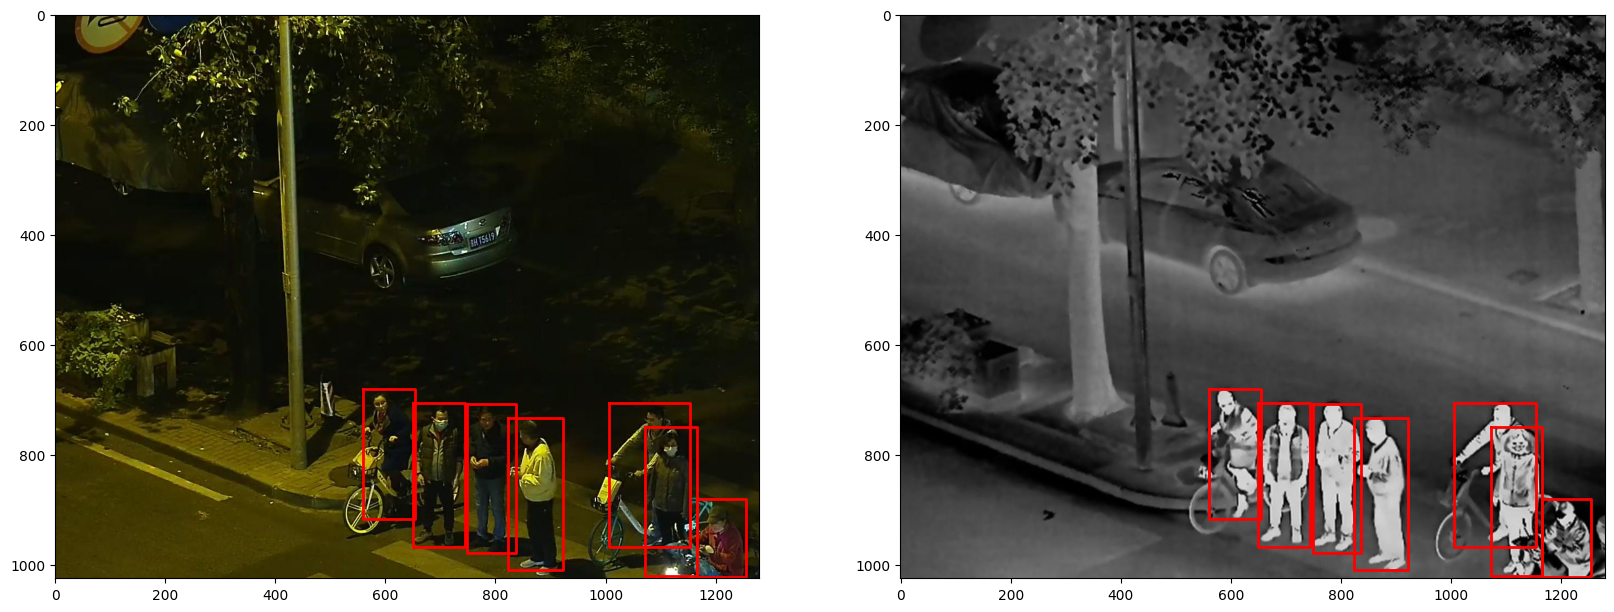

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO

flir_path = '../data/FLIR/'
llvip_path = '../data/LLVIP/'

flir_rgbimages = os.listdir(flir_path + 'images_rgb_train/data')
flir_thermalimages = os.listdir(flir_path + 'images_thermal_train/data')
llvip_rgbimages = os.listdir(llvip_path + 'visible/train')
llvip_thermalimages = os.listdir(llvip_path + 'infrared/train')

print('Number of FLIR RGB images: ', len(flir_rgbimages))
print('Number of FLIR Thermal images: ', len(flir_thermalimages))

print('Number of LLVIP RGB images: ', len(llvip_rgbimages))
print('Number of LLVIP Thermal images: ', len(llvip_thermalimages))

llvip = COCO(llvip_path + 'LLVIP.json') # load the dataset
llvip_ids = llvip.getImgIds()
img_obj = llvip.loadImgs([llvip_ids[1]])
anns_obj = llvip.loadAnns(llvip.getAnnIds(imgIds=[llvip_ids[1]]))


rgb_img = Image.open(llvip_path + 'visible/train/' + img_obj[0]['file_name'])
ir_img = Image.open(llvip_path + 'infrared/train/' + img_obj[0]['file_name'])

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
# draw bounding boxes
for ann in anns_obj:
    x, y, w, h = ann['bbox']
    plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], linewidth=2, color='r')
plt.subplot(1,2,2)
plt.imshow(ir_img)
# draw bounding boxes
for ann in anns_obj:
    x, y, w, h = ann['bbox']
    plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], linewidth=2, color='r')

plt.show()

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


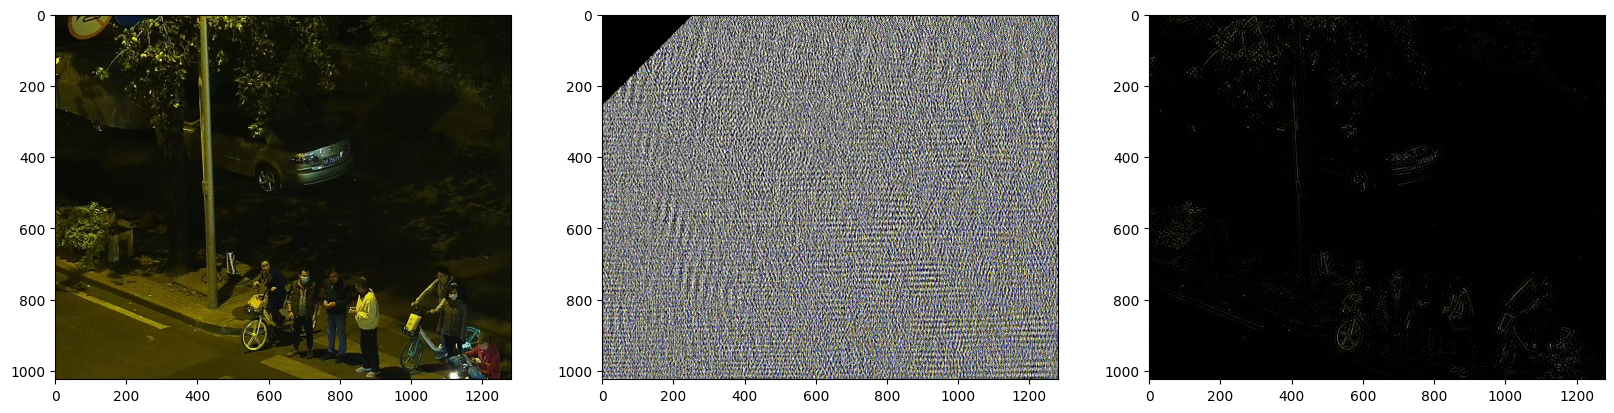

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


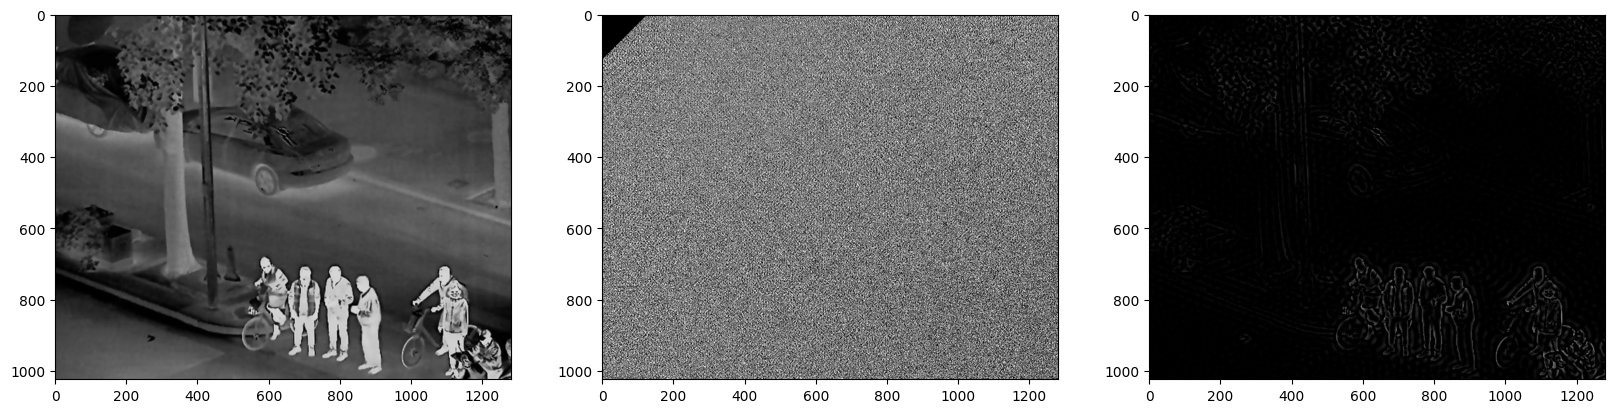

In [2]:
import torch
from torchvision import transforms
import tools.dct as dct
import matplotlib.gridspec as gridspec
transforms = transforms.Compose([transforms.ToTensor()])

def plot_dct(input, masked_freq, output):
    gs = gridspec.GridSpec(1, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(gs[0,0])
    plt.imshow(input.permute(1,2,0))
    plt.subplot(gs[0,1])
    plt.imshow(masked_freq.permute(1,2,0))
    plt.subplot(gs[0,2])
    plt.imshow(output.permute(1,2,0))
    plt.show()

rgb_tensor = transforms(rgb_img)

dct_tensor = dct.dct_2d(rgb_tensor)

masked_tensor = dct.mask_image(dct_tensor, 0.1)

masked_rgb = dct.idct_2d(masked_tensor)

plot_dct(rgb_tensor, masked_tensor, masked_rgb)

ir_tensor = transforms(ir_img)

dct_tensor = dct.dct_2d(ir_tensor)

masked_tensor = dct.mask_image(dct_tensor, 0.05)

masked_ir = dct.idct_2d(masked_tensor)

plot_dct(ir_tensor, masked_tensor, masked_ir)

In [7]:
from model import *

model = InfusionNet(num_features=64, reduction=32, tau=0.2)
model

InfusionNet(
  (rgb_phase_0): InputPhaseBlock(
    (four_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
    )
    (base_conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (final_conv): Sequential(
      (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (ir_phase_0): InputPhaseBlock(
    (four_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_

In [9]:
input_img = torch.cat((rgb_tensor, ir_tensor), dim=0).unsqueeze(0)
print(input_img.shape)
output_img = model(input_img)

torch.Size([1, 6, 1024, 1280])


: 

: 